# EDA for the Multimodal Single-Cell Integration Competition

In [1]:
import os, gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

DATA_DIR = "./input/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [2]:
%%time
# If you see a warning "Failed to establish a new connection" running this cell,
# go to "Settings" on the right hand side, 
# and turn on internet. Note, you need to be phone verified.
# We need this library to read HDF files.
# !pip install --quiet tables


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


# Loading

In [3]:
DATA_DIR = "./input/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# The metadata table

The metadata table (which includes training and test data) shows us:
- There is data about 281528 unique cells.
- The table has no missing values.
- The cells belong to five days, four donors, eight cell types (including one type named 'hidden'), and two technologies.

**Insight:** 
- Every cell is used only on a single day and then discarded. There are no time series over single cells.
- The two technologies do not share cells. It looks like we may create two completely independent models, one per technology, even if they share the same four donors. It's two Kaggle competitions in one!
- As the models are independent, it is a good idea to work with two separate notebooks, one for CITEseq, the other one for Multiome.

In [4]:
df_cell = pd.read_csv(FP_CELL_METADATA)
display(df_cell)
print('days: ', set(df_cell.day))
print('cell types: ', set(df_cell.cell_type))
print('technology: ', set(df_cell.technology))
print('donor: ', set(df_cell.donor))
if not df_cell.cell_id.duplicated().any(): print('All cell_ids are unique.')
if not df_cell.isna().any().any(): print('There are no missing values.')
    

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...,...
281523,96a60b026659,10,31800,hidden,multiome
281524,d493e546991e,10,31800,hidden,multiome
281525,05666c99aa48,10,31800,hidden,multiome
281526,121f946642b5,10,31800,hidden,multiome


days:  {2, 3, 4, 7, 10}
cell types:  {'hidden', 'NeuP', 'HSC', 'BP', 'MkP', 'MoP', 'EryP', 'MasP'}
technology:  {'multiome', 'citeseq'}
donor:  {13176, 32606, 31800, 27678}
All cell_ids are unique.
There are no missing values.


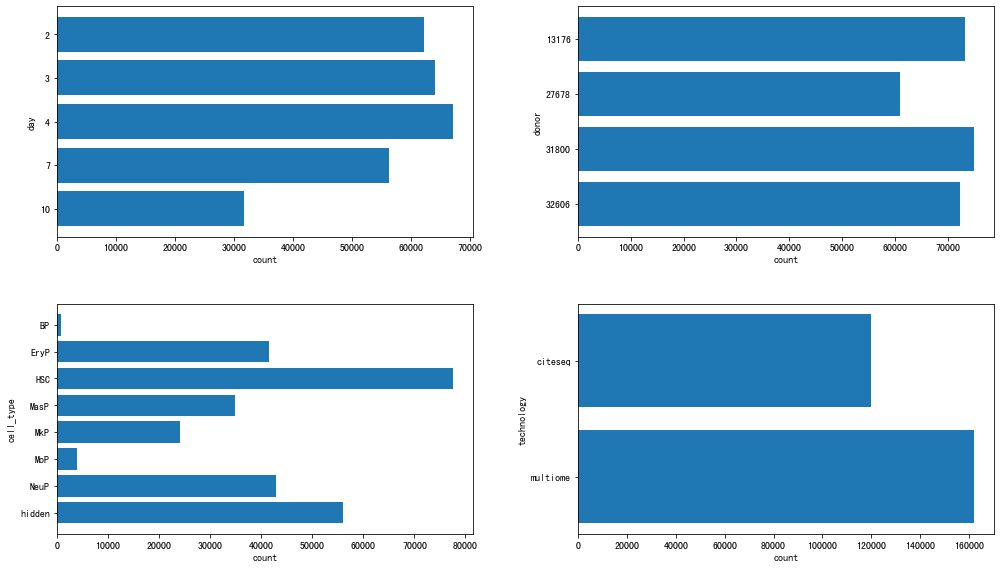

In [5]:
_, axs = plt.subplots(2, 2, figsize=(14, 8))
for col, ax in zip(['day', 'donor', 'cell_type', 'technology'], axs.ravel()):
    vc = df_cell[col].astype(str).value_counts()
    if col == 'day':
        vc.sort_index(key = lambda x : x.astype(int), ascending=False, inplace=True)
    else:
        vc.sort_index(ascending=False, inplace=True)
    ax.barh(vc.index, vc)
    ax.set_ylabel(col)
    ax.set_xlabel('count')
plt.tight_layout(h_pad=4, w_pad=4)
plt.show()


The CITEseq measurements took place on four days, the Multiome measurements on five (except that there are no measurements for donor 27678 on day 4. For every combination of day, donor and technology, there are around 8000 cells:

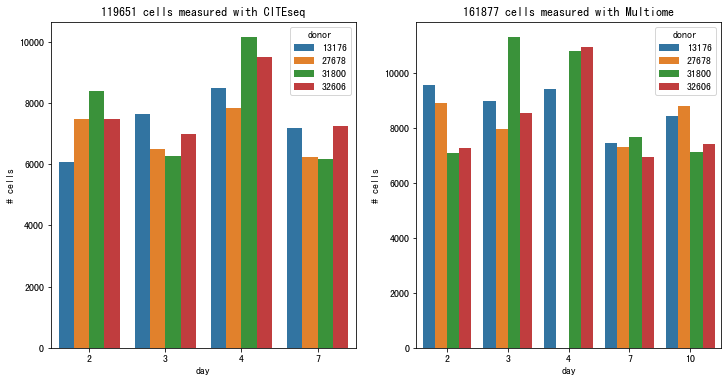

Average: 8044


In [6]:
# From https://www.kaggle.com/code/peterholderrieth/getting-started-data-loading
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]

fig, axs = plt.subplots(1,2,figsize=(12,6))
df_cite_cell_dist = df_cell_cite.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_cite_cell_dist, x="day",hue="donor",y="# cells", ax=axs[0])
axs[0].set_title(f"{len(df_cell_cite)} cells measured with CITEseq")

df_multi_cell_dist = df_cell_multi.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_multi_cell_dist, x="day",hue="donor",y="# cells", ax=axs[1])
axs[1].set_title(f"{len(df_cell_multi)} cells measured with Multiome")
plt.show()
print('Average:', round(len(df_cell) / 35))

# CITEseq

## Inputs

The CITEseq input files contain 70988 samples (i.e., cells) for train and 48663 samples for test. 70988 + 48663 = 119651, which matches the number of rows in the CITEseq metadata table. No values are missing.

The input data corresponds to RNA expression levels for 22050 genes (there are 22050 columns).

The data have dtype float32, which means we need 119651 * 22050 * 4 = 10553218200 bytes = 10.6 GByte of RAM just for the input data without the targets. 

Originally, these RNA expression levels were counts (i.e., nonnegative integers), but they have been normalized and log1p-transformed. With the log1p transformation, the data remain nonnegative.

Most columns have a minimum of zero, which means that for most genes there are cells which didn't express this gene (the count was 0). In fact, 78 % of all table entries are zero, and for some columns, the count is always zero.

**Insight:**
- This is big data. Make sure you don't waste RAM and use efficient algorithms.
- Perhaps we should first load only the training data into RAM, fit one or more models, and then delete the training data from RAM before loading the test data.
- The columns which are zero for every cell should be dropped before modeling.

In [9]:
%%time
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
display(df_cite_train_x.head())
df_cite_test_x = pd.read_hdf(FP_CITE_TEST_INPUTS)
print('Shapes:', df_cite_train_x.shape, df_cite_test_x.shape, df_cell_cite.shape)
print("Missing values:", df_cite_train_x.isna().sum().sum(), df_cite_test_x.isna().sum().sum())
print("Genes which never occur in train:", (df_cite_train_x == 0).all(axis=0).sum())
print("Genes which never occur in test: ", (df_cite_test_x == 0).all(axis=0).sum())
print(f"Zero entries in train: {(df_cite_train_x == 0).sum().sum() / df_cite_train_x.size:.0%}")
print(f"Zero entries in test:  {(df_cite_test_x == 0).sum().sum() / df_cite_test_x.size:.0%}")


gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


Shapes: (70988, 22050) (48663, 22050) (119651, 5)
Missing values: 0 0
Genes which never occur in train: 449
Genes which never occur in test:  745
Zero entries in train: 78%
Zero entries in test:  78%
CPU times: user 39.8 s, sys: 7.63 s, total: 47.5 s
Wall time: 43.9 s


In [14]:
70988 + 48663

119651

In [15]:
df_cite_test_x = None # release the memory


The histogram shows some artefacts, maybe because the data originally were integers.

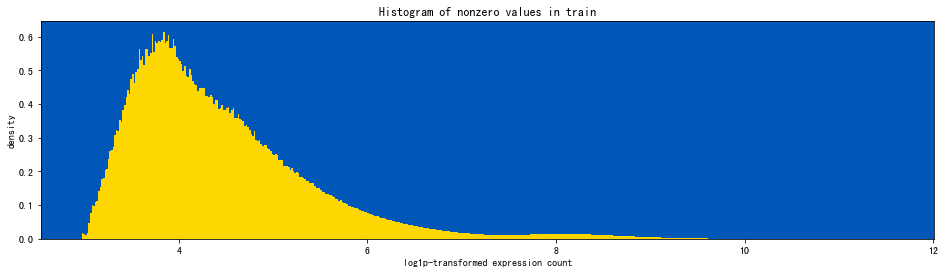

CPU times: user 15.7 s, sys: 2.07 s, total: 17.7 s
Wall time: 17.7 s


In [16]:
%%time
nonzeros = df_cite_train_x.values.ravel()
nonzeros = nonzeros[nonzeros != 0]
plt.figure(figsize=(16, 4))
plt.gca().set_facecolor('#0057b8')
plt.hist(nonzeros, bins=500, density=True, color='#ffd700')
del nonzeros
plt.title("Histogram of nonzero values in train")
plt.xlabel("log1p-transformed expression count")
plt.ylabel("density")
plt.show()

## Targets

The CITEseq output (target) file is much smaller - it has 70988 rows like the training input file, but only 140 columns. The 140 columns correspond to 140 proteins.

The targets are dsb-normalized surface protein levels. We plot the histograms of a few selected columns and see that the distributions vary: some columns are normally distributed, some columns are multimodal, some have other shapes, and there seem to be outliers.

**Insight:**
- This is a multi-output regression problem with 140 outputs. We won't be able to apply some standard methods of single-output regression - e.g., we can't compute the correlation between every feature and the target. 

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


Output shape: (70988, 140)


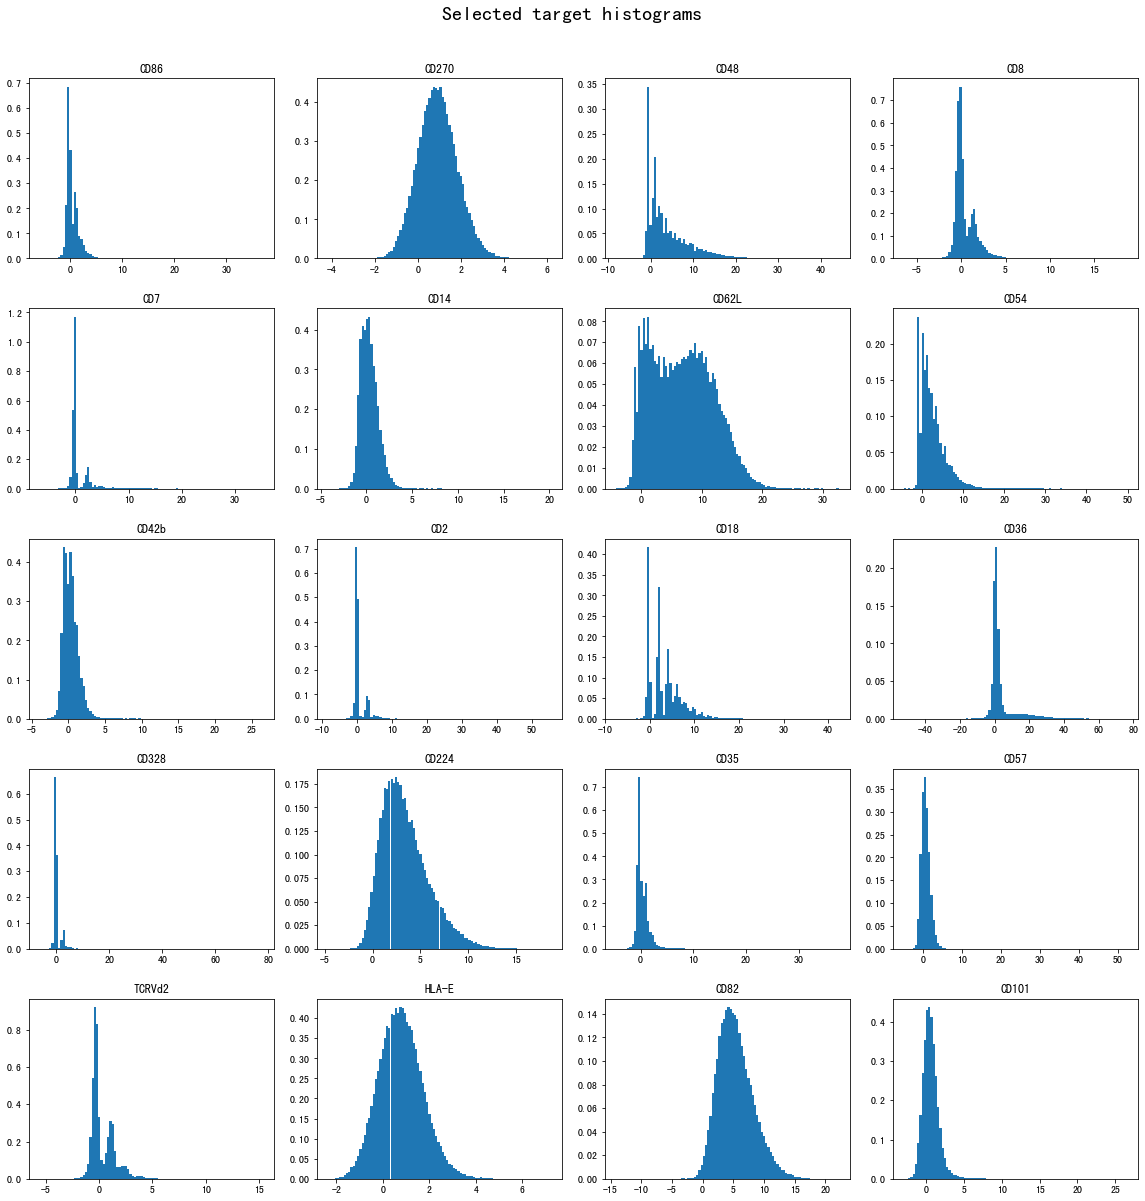

In [17]:
df_cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
display(df_cite_train_y.head())
print('Output shape:', df_cite_train_y.shape)

_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(['CD86', 'CD270', 'CD48', 'CD8', 'CD7', 'CD14', 'CD62L', 'CD54', 'CD42b', 'CD2', 'CD18', 'CD36', 'CD328', 'CD224', 'CD35', 'CD57', 'TCRVd2', 'HLA-E', 'CD82', 'CD101'], axs.ravel()):
    ax.hist(df_cite_train_y[col], bins=100, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Selected target histograms', fontsize=20, y=1.04)
plt.show()

In [18]:
df_cite_train_x, df_cite_train_y = None, None # release the memory

# Multiome

## Input

The Multiome dataset is much larger than the CITEseq part and way too large to fit into 16 GByte RAM:
- train inputs:  105942 * 228942 float32 values (97 GByte)
- train targets: 105942 *  23418 float32 values (10 GByte)
- test inputs:    55935 * 228942 float32 values (13 GByte)

No values are missing.

The data consists of ATAC-seq peak counts transformed with TF-IDF. They are all nonnegative. In the sample we are looking at, 98 % of the entries are zero, and thousands of columns are always zero.

**Insight:**
- The Multiome data is even bigger data than the CITEseq data. Most of us can't afford notebooks with 97 GByte RAM.
- Dimension reduction and feature selection will be key to get successful models.
- Maybe we can do something with sparse array data structures.
- Maybe we can train on a subset of the rows (and sacrifice some precision).
- Maybe we can convert the data to float16.
- We should never have training and test data in memory at the same time.
- We may even want to look for algorithms which don't need all the training data in RAM at the same time. Neural networks are a candidate.
- The columns which are zero for every cell should be dropped before modeling.
- The training set has n_features > n_samples. We'll use algorithms which can deal with more features than samples.


In [19]:
%%time
# Look at the training data
start = 0
chunksize = 5000
total_rows = 0
while True:
    df_multi_train_x = pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS, start=start, stop=start+chunksize)
    if df_multi_train_x.isna().any().any(): print('There are missing values.')
    if (df_multi_train_x < 0).any().any(): print('There are negative values.')
    total_rows += len(df_multi_train_x)
    print(total_rows)
    if len(df_multi_train_x) < chunksize: break
    start += chunksize
display(df_multi_train_x.head())
print("Genes which never occur in train:", (df_multi_train_x == 0).all(axis=0).sum())
print(f"Zero entries in train: {(df_multi_train_x == 0).sum().sum() / df_multi_train_x.size:.0%}")


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
105942


gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
13cb628b8773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0803092e6b4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.082841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e8e7ff56f262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238fab57f568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a15df1e31860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Genes which never occur in train: 15762
Zero entries in train: 98%
CPU times: user 3min 50s, sys: 56.4 s, total: 4min 47s
Wall time: 4min 13s


In [13]:
df_multi_train_x = None # release the memory

In [14]:
%%time
# Look at the test data
start = 0
chunksize = 5000
total_rows = 0
while True:
    df_multi_test_x = pd.read_hdf(FP_MULTIOME_TEST_INPUTS, start=start, stop=start+chunksize)
    if df_multi_test_x.isna().any().any(): print('There are missing values.')
    if (df_multi_test_x < 0).any().any(): print('There are negative values.')
    total_rows += len(df_multi_test_x)
    print(total_rows)
    if len(df_multi_test_x) < chunksize: break
    start += chunksize
    
df_multi_test_x.head()

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
55935
CPU times: user 4min 4s, sys: 47.8 s, total: 4min 51s
Wall time: 5min 2s


gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
079ddaa2be77,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43ee19ddefb3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f82d95f0637f,0.0,0.0,0.0,2.372443,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d49fa69ad100,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cffc5965c70,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.626008,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Target

The Multiome targets (RNA count data) are in similar shape as the CITEseq inputs: They have 105942 rows and 23418 columns. All targets are nonnegative and no values are missing.


In [15]:
%%time
start = 0
chunksize = 10000
total_rows = 0
while True:
    df_multi_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=start, stop=start+chunksize)
    if df_multi_train_y.isna().any().any(): print('There are missing values.')
    if (df_multi_train_y < 0).any().any(): print('There are negative values.')
    total_rows += len(df_multi_train_y)
    print(total_rows)
    if len(df_multi_train_y) < chunksize: break
    start += chunksize
    
display(df_multi_train_y.head())


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
105942


gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000256661,ENSG00000184389,ENSG00000128274,ENSG00000094914,ENSG00000081760,...,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
cell_id,,,,,,,,,,,,,,,,,,,,,
1777f8908031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,6.271747,0.0,0.000000,0.000000,0.000000
7b88c4c3021b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,4.251612,0.000000,0.0,0.0,5.627168,0.0,0.000000,4.251612,5.340685
34f17c8aece8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,5.349229,0.0,0.0,0.000000,0.0,4.660822,5.753109,0.000000
f02fabdccd4b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.606937,4.606937,...,0.000000,4.606937,0.000000,0.0,0.0,4.606937,0.0,0.000000,0.000000,0.000000
6083c6994d3e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,4.245897,0.000000,4.245897,0.0,0.0,0.000000,0.0,0.000000,0.000000,4.931858


CPU times: user 50.8 s, sys: 10.2 s, total: 1min
Wall time: 1min 21s


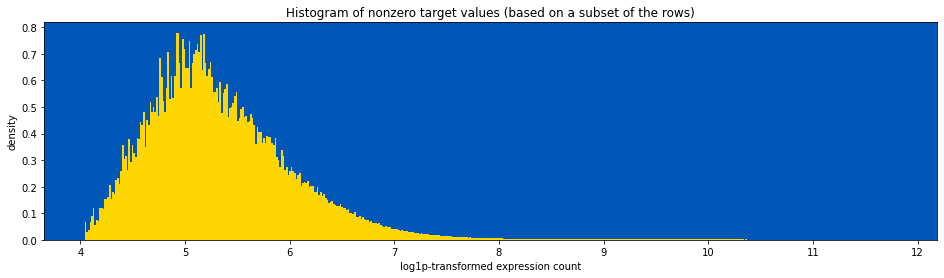

CPU times: user 2.76 s, sys: 322 ms, total: 3.08 s
Wall time: 2.84 s


In [16]:
%%time
nonzeros = df_multi_train_y.values.ravel()
nonzeros = nonzeros[nonzeros != 0]
plt.figure(figsize=(16, 4))
plt.gca().set_facecolor('#0057b8')
plt.hist(nonzeros, bins=500, density=True, color='#ffd700')
del nonzeros
plt.title("Histogram of nonzero target values (based on a subset of the rows)")
plt.xlabel("log1p-transformed expression count")
plt.ylabel("density")
plt.show()

df_multi_train_y = None # release the memory

# Summary

This is a big data competition. The more RAM you have, the better.

After this EDA, you may want to look at two models which generate predictions in spite of having only 16 GB RAM:
- [MSCI CITEseq Quickstart](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart)
- [MSCI Multiome Quickstart](https://www.kaggle.com/ambrosm/msci-multiome-quickstart)